In [3]:

import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import sys

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import pickle

import warnings
warnings.filterwarnings('ignore')

C:\Users\Georgy\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [14]:
from scipy.special import softmax

inp = np.array([[1,0,2],[0,1,3],[1,3,0],[0,0,0]])
unnorm_scores = inp.dot(np.array([0,0,1]))
attr_scores = softmax(unnorm_scores)
attr_scores.dot(inp)

array([0.28461991, 0.78323514, 2.54574246])

In [2]:
def tsplot(y, lags=None, figsize=(15, 10), style='seaborn-whitegrid', title='title'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        #pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, title='Значения автокорреляции')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ-график')        
        #scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [3]:
def data_yahoo(ticker_list, names):
    data_dict = {}
    for ticker, name in zip(ticker_list, names):
        data = pdr.get_data_yahoo(ticker)
        data['Returns'] = data['Adj Close'].pct_change(1)
        data.dropna(inplace=True)
        data['Ret_abs'] = data['Returns'].apply(abs)
        data['Ret_sq'] = data['Returns'].apply(lambda x: x**2)
        data_dict[name] = data
    
    return data_dict

def my_acfs(data_dict, lags=40, returns='abs'):
    if returns =='signed':
        plt.figure(figsize=(15,5))
        plt.title('Автокорреляция значений доходности')
        plt.ylabel('Значение автокорреляционной функции')
        plt.xlabel('Лаг')
        for d in data_dict.keys():
            acf_data = smt.acf(data_dict[d]['Returns'], nlags=lags)
            plt.plot(acf_data, alpha=0.7, label=str(d))
        plt.legend()
        plt.grid(b=True, alpha=0.2)
        plt.show()
    
    elif returns =='abs':
        plt.figure(figsize=(15,5))
        plt.title('Автокорреляция абсолютных значений доходности')
        plt.ylabel('Значение автокорреляционной функции')
        plt.xlabel('Лаг')
        for d in data_dict.keys():
            acf_data = smt.acf(data_dict[d]['Ret_abs'], nlags=lags)
            plt.plot(acf_data, alpha=0.7, label=str(d))
        plt.legend()
        plt.grid(b=True, alpha=0.2)
        plt.show()
        
    elif returns =='sq':
        plt.figure(figsize=(15,5))
        plt.title('Автокорреляция значений доходностей в квадрате')
        plt.ylabel('Значение автокорреляционной функции')
        plt.xlabel('Лаг')
        for d in data_dict.keys():
            acf_data = smt.acf(data_dict[d]['Ret_sq'], nlags=lags)
            plt.plot(acf_data,alpha=0.95, label=str(d))
        plt.legend()
        plt.grid(b=True, alpha=0.2)
        plt.show()
        
    
def plot_ret(name, data_dict, returns='signed'):
    if returns == 'signed':
        plt.figure(figsize=(15,5))
        plt.title('Значения дневной доходности {}'.format(name))
        plt.xlabel('Дата')
        plt.ylabel('Доходность')
        plt.plot(data_dict[name]['Returns'])
        plt.grid(alpha=0.2)
        plt.show()
    elif returns == 'abs':
        plt.figure(figsize=(15,5))
        plt.title('Абсолютные значения дневной доходности {}'.format(name))
        plt.xlabel('Дата')
        plt.ylabel('Доходность')
        plt.plot(data_dict[name]['Ret_abs'])
        plt.grid(alpha=0.2)
        plt.show()
    elif returns == 'sq':
        plt.figure(figsize=(15,5))
        plt.title('Значения дневной доходности в квадрате{}'.format(name))
        plt.xlabel('Дата')
        plt.ylabel('Доходность')
        plt.plot(data_dict[name]['Ret_sq'])
        plt.grid(alpha=0.2)
        plt.show()    

def plot_dist(ticker, data_dict):
    l, h = data_dict[ticker]['Returns'].min(), data_dict[ticker]['Returns'].max()
    x = np.linspace(l,h, num=data_dict[ticker].shape[0])
    m = data_dict[ticker]['Returns'].mean()
    std = data_dict[ticker]['Returns'].std()
    
    kurtosis=scs.kurtosis(data_dict[ticker]['Returns'])
    skew = scs.skew(data_dict[ticker]['Returns'])
    
    normal = scs.norm.pdf(x=x, loc=m, scale=std)
    plt.figure(figsize=(12,8))
    plt.title('Распределение доходности {}'.format(ticker))
    plt.plot(x, normal, alpha=0.8, label='(Теоретическое) нормальное распределение')
    sns.distplot(data_dict[ticker]['Returns'], hist=True, kde=True,
                 label = 'Факт. распределение доходности {} (эксцесс = {}, асимм. = {})'.format(ticker,
                                                                                        np.round(kurtosis, 2), np.round(skew, 2)))
    plt.grid(alpha=0.2)
    plt.legend(loc='upper left')
    plt.show
    

In [83]:
data_dict = data_yahoo(['^IXIC', '^GSPC', '^N225', '^GDAXI', 'IMOEX.ME', 'YNDX'], 
                       ['NASDAQ', 'S&P500', 'Nikkei 225', 'DAX','Индекс ММВБ', 'Yandex' ])

with open('data_dict_30.03.pickle', 'wb') as dd:
    pickle.dump(data_dict, dd)

In [4]:
with open('data_dict_30.03.pickle', 'rb') as dd:
    data_dict = pickle.load(dd)

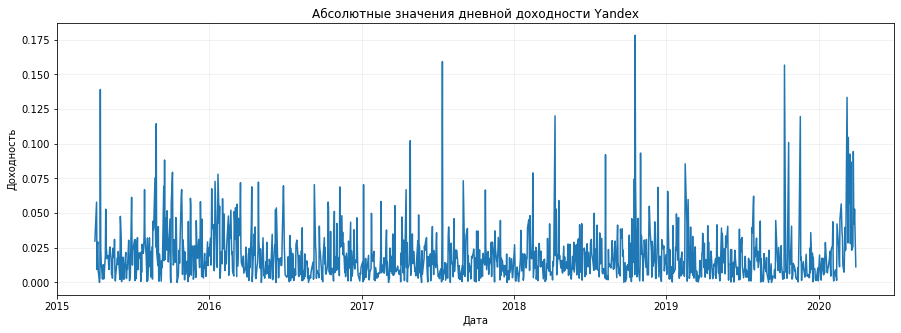

In [140]:
plot_ret('Yandex', data_dict, returns='abs')

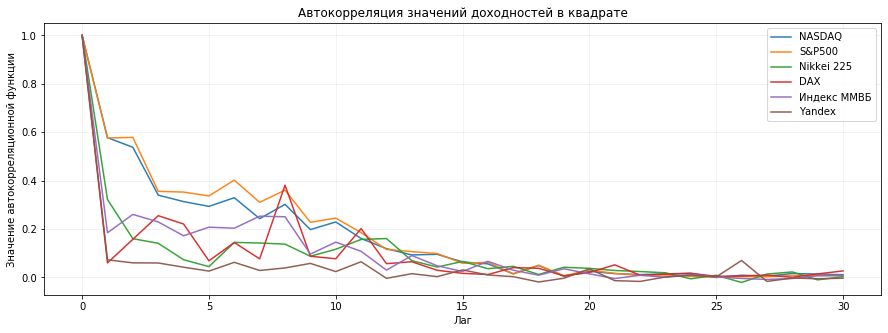

In [88]:
my_acfs(data_dict, lags=30, returns='sq')

Text(0.5, 0, 'Доходность')

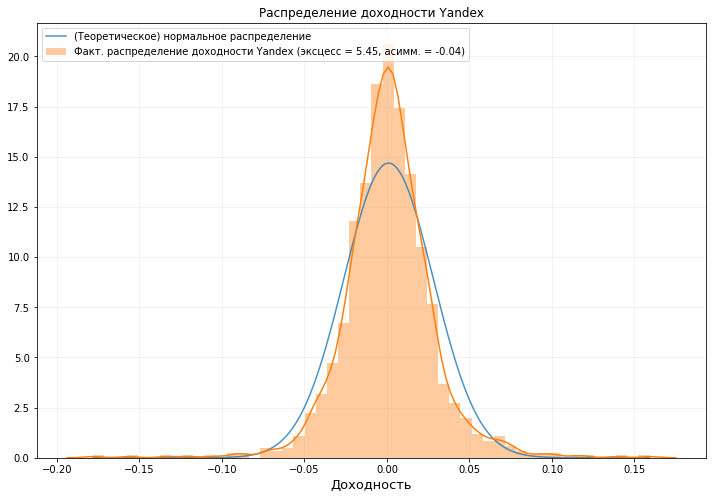

In [205]:
plot_dist('Yandex', data_dict)
plt.xlabel('Доходность', fontsize=13)

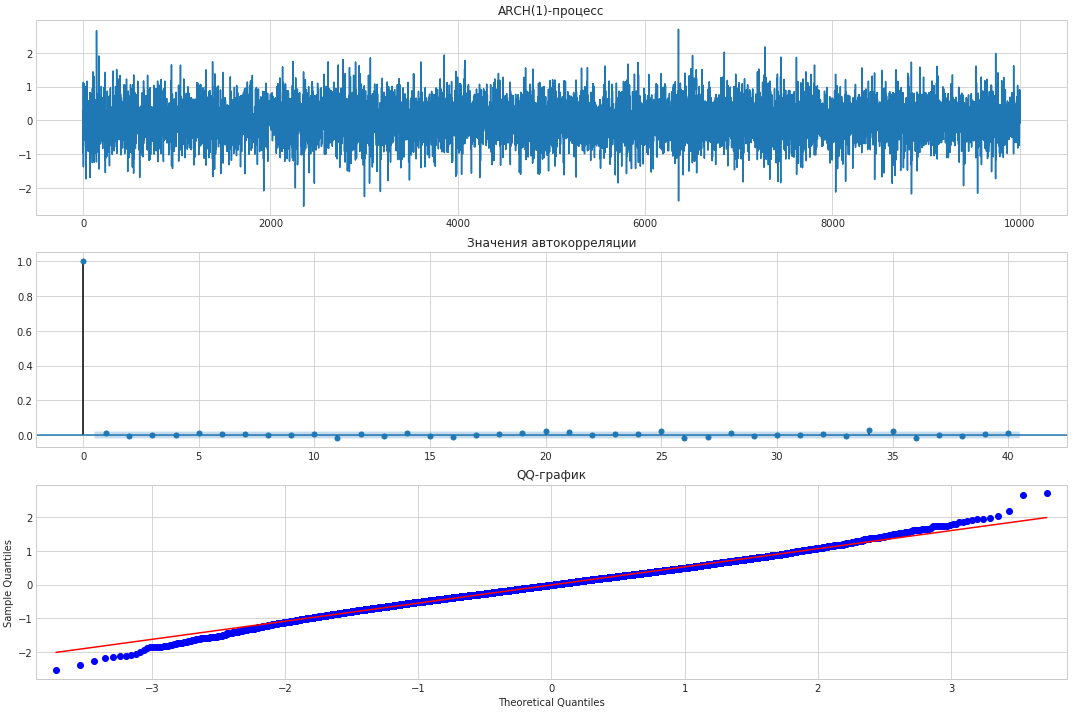

In [15]:
#ARCH(1)

np.random.seed(2)
a0 = 0.2
a1 = 0.3


w = np.random.randn(10000)
eps = sigsq = np.random.randn(10000)
for t in range(1,10000):
    sigsq[t] = a0 + a1 * (eps[t-1]**2)  
    eps[t] = w[t]*np.sqrt(sigsq[t])
    
tsplot(eps, title='ARCH(1)-процесс')

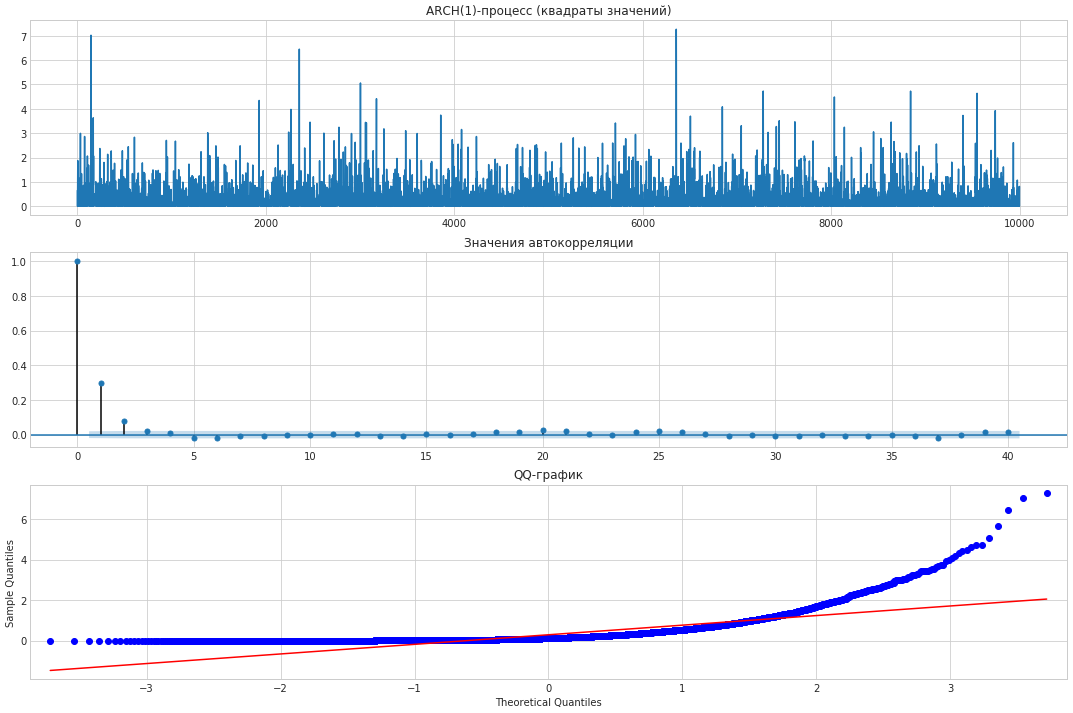

In [18]:
tsplot(eps**2, title='ARCH(1)-процесс (квадраты значений)')

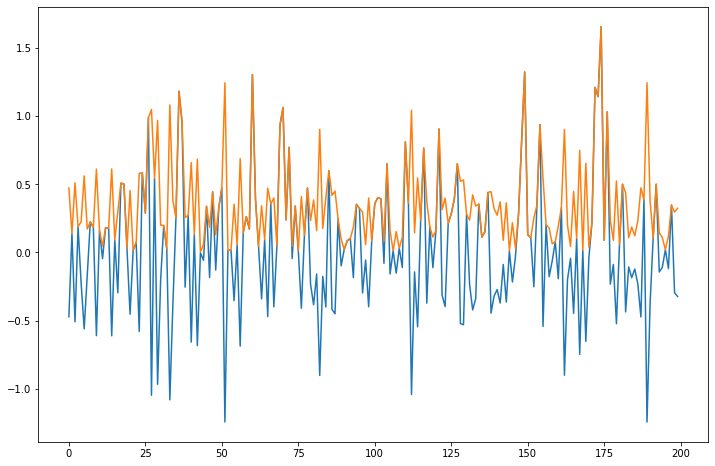

In [53]:
#GARCH(1,1)

np.random.seed(4)
a0 = 0.2
a1 = 0.3
b1 = 0.4

w = np.random.randn(200)
eps = sigsq = np.random.randn(200)
for t in range(1,200):
    sigsq[t] = a0+ (a1 * (eps[t-1]**2))  + (b1 * sigsq[t-1])
    eps[t] = w[t]*np.sqrt(sigsq[t])

plt.figure(figsize=(12,8))    
plt.plot(eps)
plt.plot(np.sqrt(eps**2))


In [70]:
print("Корреляция между волатильностью и доходностью (S&P500): {}".format( data_dict['S&P500']['Ret_abs'].corr(data_dict['S&P500']['Returns'])))
print("Корреляция между волатильностью и доходностью (NASDAQ): {}".format(data_dict['NASDAQ']['Ret_abs'].corr(data_dict['NASDAQ']['Returns'])))

Корреляция между волатильностью и доходностью (S&P500): -0.13629616476401213
Корреляция между волатильностью и доходностью (NASDAQ): -0.13843384574044337


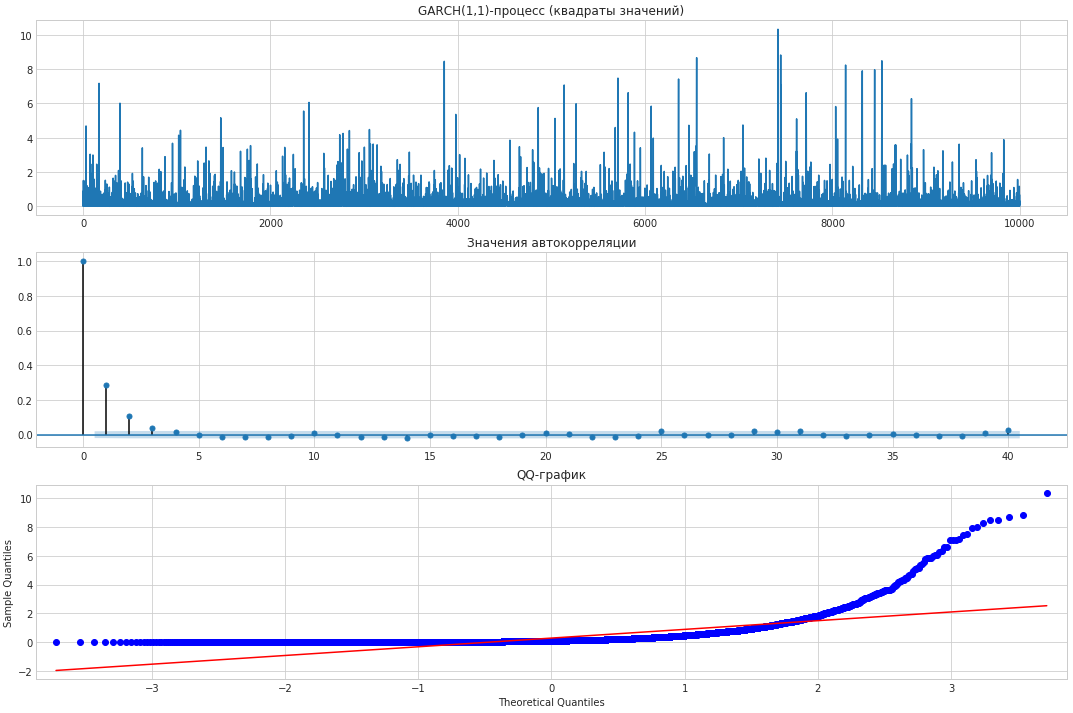

In [40]:
#GARCH(1,1)

np.random.seed(2)
a0 = 0.2
a1 = 0.3
b1 = 0.4

w = np.random.randn(10000)
eps = sigsq = np.random.randn(10000)
for t in range(1,10000):
    sigsq[t] = a0+ (a1 * (eps[t-1]**2))  + (b1 * sigsq[t-1])
    eps[t] = w[t]*np.sqrt(sigsq[t])
    
tsplot(eps**2, title='GARCH(1,1)-процесс (квадраты значений)')

count    1257.000000
mean        0.096557
std         2.716027
min       -17.809368
25%        -1.315791
50%         0.073369
75%         1.485651
max        15.916577
Name: Returns, dtype: float64


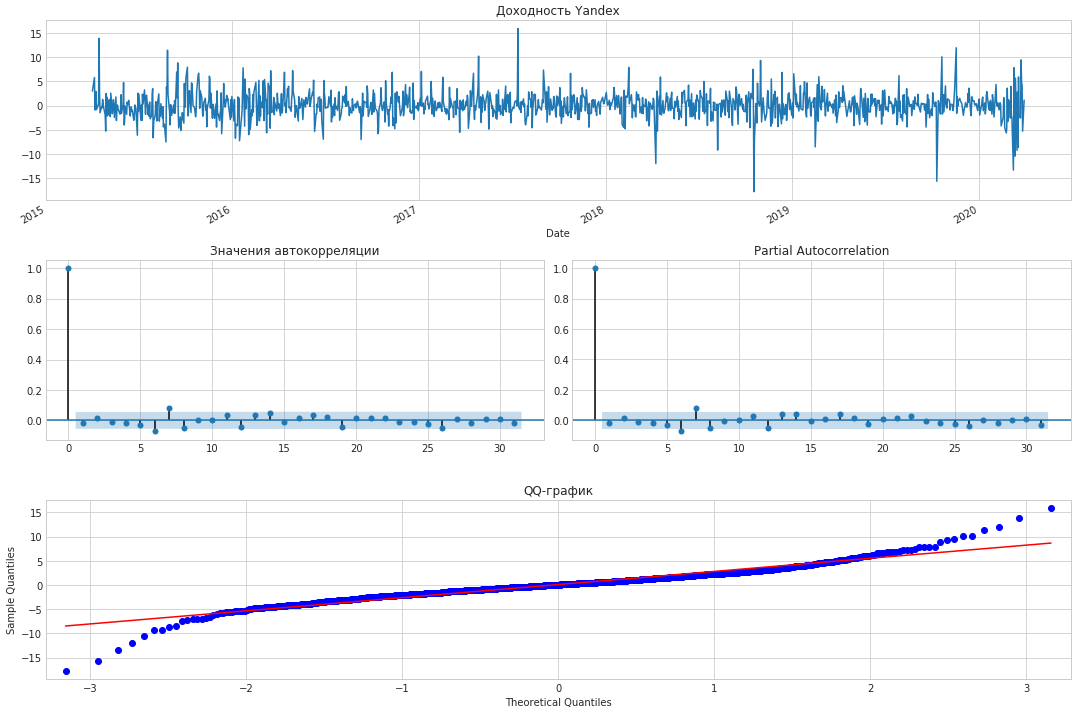

In [141]:
ret = data_dict['Yandex']['Returns']

ret = ret * 100
print(ret.describe())
last_observation = ret.index[len(ret)//2]
tsplot(ret, title='Доходность Yandex')

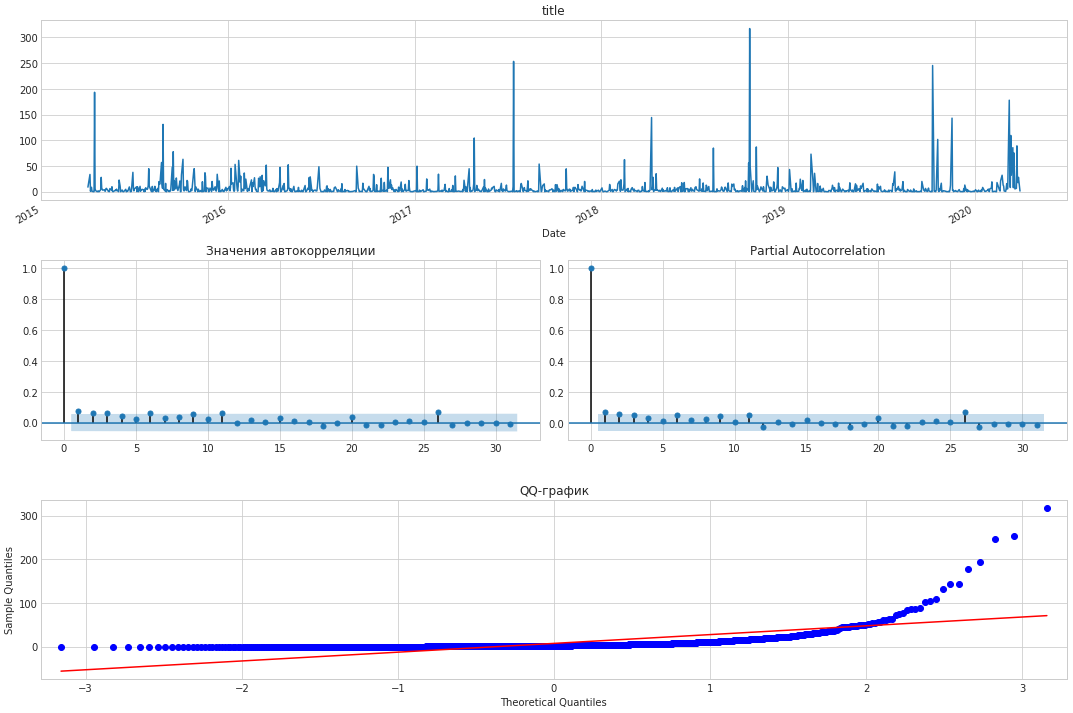

In [142]:
tsplot(ret**2)

In [178]:
#GARCH(1,1)

garch = arch_model(ret, vol='Garch', p=1, q=1, power=2.0).fit(last_obs=last_observation, disp='off')
in_sample_variance = garch.conditional_volatility ** 2
print(garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1515.97
Distribution:                  Normal   AIC:                           3039.94
Method:            Maximum Likelihood   BIC:                           3057.71
                                        No. Observations:                  628
Date:                Mon, Mar 30 2020   Df Residuals:                      624
Time:                        22:34:03   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1551      0.108      1.439      0.150 [-5.62

In [179]:
forecast = garch.forecast(align='target')
out_of_sample_variance = forecast.variance
out_of_sample_variance.dropna().tail()


,h.1
Date,
2020-03-24,12.352494
2020-03-25,13.212484
2020-03-26,13.056014
2020-03-27,12.830300
2020-03-30,12.817040


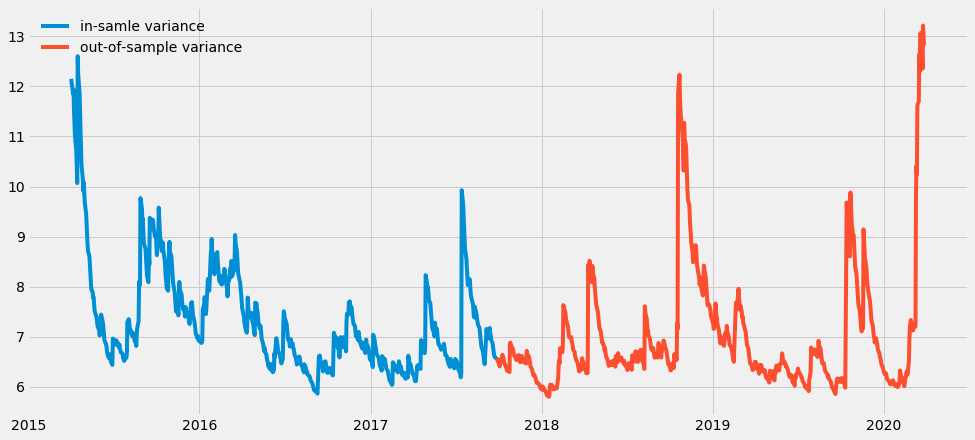

In [180]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(15,7))
    plt.plot(in_sample_variance, label='in-samle variance')
    plt.plot(out_of_sample_variance, label='out-of-sample variance')
    plt.legend(loc='upper left', frameon=0)
    


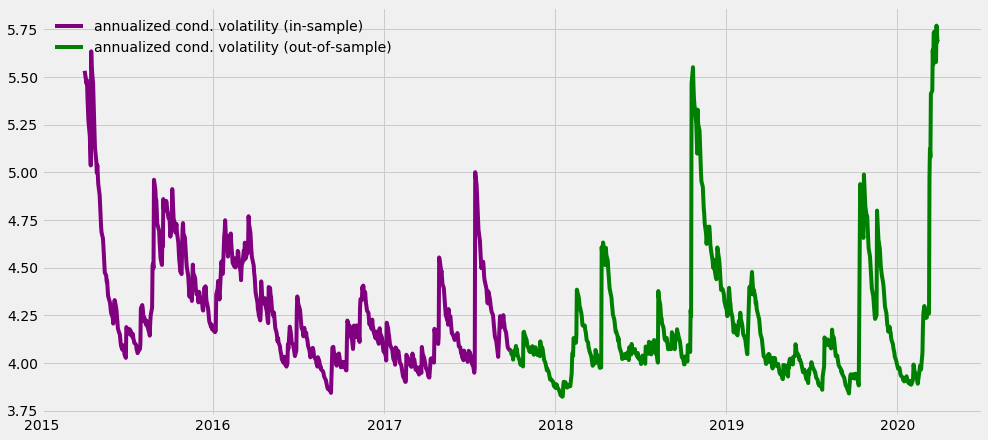

In [181]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(15,7))
    plt.plot(np.sqrt(252*in_sample_variance/100), label='annualized cond. volatility (in-sample)', color='purple')
    plt.plot(np.sqrt(252*out_of_sample_variance/100), label='annualized cond. volatility (out-of-sample)', color='green')
    plt.legend(loc='upper left', frameon=0)

In [190]:
def ReplaceLetters(string_input):
    
    list_input = [letter if letter not in ['a', 'e', 'o'] else letter.upper() for letter in string_input]
    
    return "".join(list_input)
    

In [191]:
ReplaceLetters('asd eoa')

'Asd EOA'

In [27]:

results_arima = {
    'best_aic': float('inf'),
    'best_order': (0,0,0),
    'best_model': None
     }
    
for p in range(1,5):
    for q in range(1,5):

        try:
            arima_result = smt.ARIMA(sp[:500], order=(p,0,q)).fit(method='mle')
            if arima_result.aic < results_arima['best_aic']:
                results_arima['best_aic'] = arima_result.aic
                results_arima['best_order'] = (p,0,q)
                results_arima['best_model'] = arima_result
        except:
            continue


In [71]:
arima_resid = m.resid
garch_res = arch_model(sp[:500],dist='StudentsT').fit(update_freq=5)
print(garch_res.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: -1374.5332655369116
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1374.534247555182
            Iterations: 13
            Function evaluations: 109
            Gradient evaluations: 9
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      Returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                1374.53
Distribution:      Standardized Student's t   AIC:                          -2739.07
Method:                  Maximum Likelihood   BIC:                          -2718.00
                                              No. Observations:                  500
Date:                      Sun, Mar 29 2020   Df Residuals:                      495
Time:                     

C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


TypeError: forecast() got an unexpected keyword argument 'horizont'

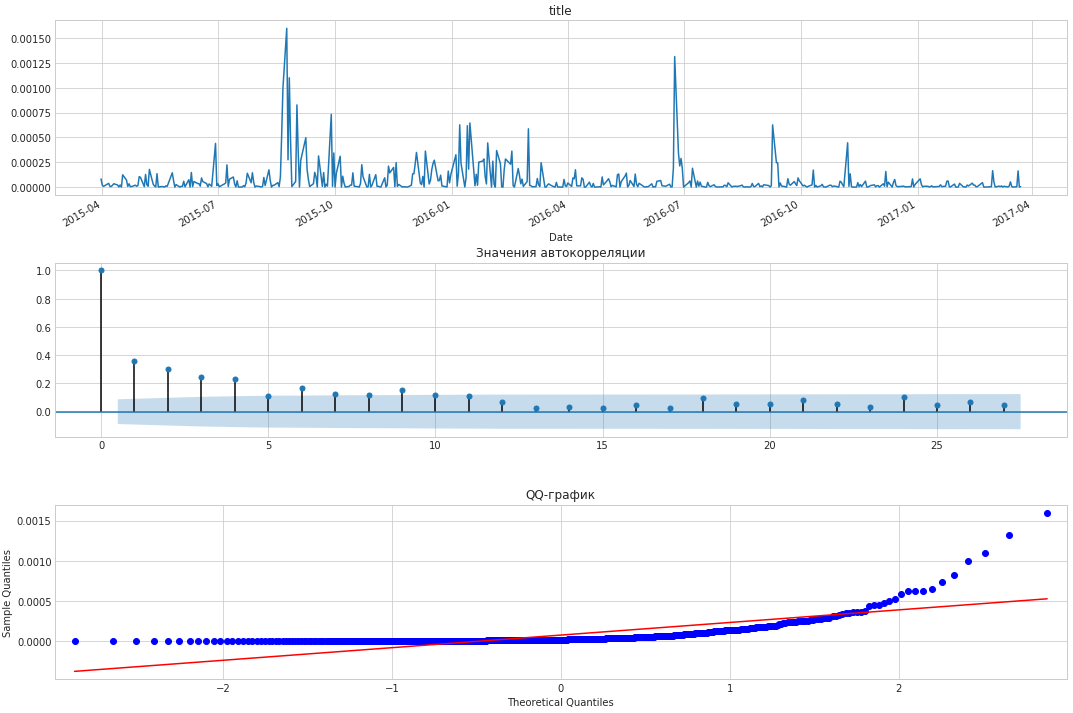

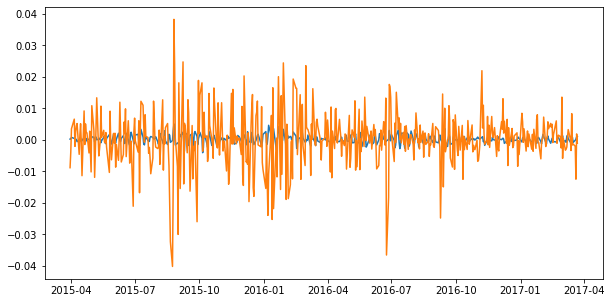

In [80]:
m = results_arima['best_model']
plt.figure(figsize=(10,5))
plt.plot(m.fittedvalues)
plt.plot(sp[:500])

In [40]:
garch = arch_model(arima_resids).fit(update_freq=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1729.0345744009908
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1729.5157659507436
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1729.6138598022042
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1729.6150244686264
Iteration:      5,   Func. Count:     60,   Neg. LLF: -1729.6150387454745
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1729.6150389600398
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


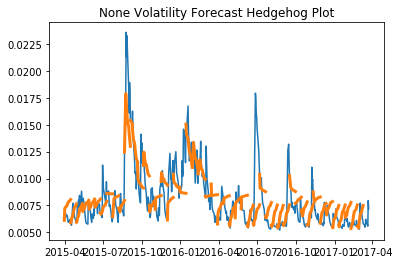

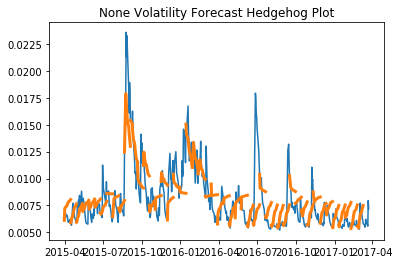

In [42]:
garch.hedgehog_plot()

In [20]:
model = arch_model(eps, dist='Normal').fit(update_freq=1)
print(model.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8643.65423482375
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8636.105292572658
Iteration:      3,   Func. Count:     25,   Neg. LLF: 8515.38462516116
Iteration:      4,   Func. Count:     32,   Neg. LLF: 8483.625929948365
Iteration:      5,   Func. Count:     39,   Neg. LLF: 8427.61211846727
Iteration:      6,   Func. Count:     45,   Neg. LLF: 8346.874198613057
Iteration:      7,   Func. Count:     52,   Neg. LLF: 8345.083776648504
Iteration:      8,   Func. Count:     59,   Neg. LLF: 8338.848212606943
Iteration:      9,   Func. Count:     65,   Neg. LLF: 8337.17499063057
Iteration:     10,   Func. Count:     71,   Neg. LLF: 8337.15835415141
Iteration:     11,   Func. Count:     77,   Neg. LLF: 8337.147572429545
Iteration:     12,   Func. Count:     83,   Neg. LLF: 8337.147063028635
Iteration:     13,   Func. Count:     89,   Neg. LLF: 8337.147024998458
Optimization terminated successfully.    (Exit mode 0)
            Cu

In [124]:
am = arch_model(e)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 13757.249172730288
Iteration:     10,   Func. Count:     70,   Neg. LLF: 13747.026480045715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 13747.026402048761
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -13747.0
Distribution:                  Normal   AIC:                           27502.1
Method:            Maximum Likelihood   BIC:                           27530.9
                                        No. Observations:                10000
Date:                Thu, Mar 19 2020   Df Residuals:                     9996
Time:      

In [125]:
def best_model(timeseries):
    best_aic = float('inf')
    best_order = None
    best_model = None
    
    pqs = range(5)
    diffs = range(2)
    
    for p in pqs:
        for d in diffs:
            for q in pqs:
                
                try:
                    temp_model = smt.ARIMA(timeseries, order=(p,d,q)).fit(method='mle', trend='nc')
                    temp_aic = temp_model.aic
                    
                    if temp_aic < best_aic:
                        best_aic = temp_aic
                        best_order = (p,d,q)
                        best_model = temp_model
                except:
                    continue
                    
    print("Best AIC: {}; best model: ARIMA{}".format(best_aic, best_order))
    return best_aic, best_order, best_model
                        

In [127]:
moex = pandas_datareader.get_data_yahoo('IMOEX.ME')
moex['Return'] = moex['Adj Close'].pct_change()
ts = moex['Return']

In [130]:
ts.dropna(inplace=True)
ts = ts[:500]

In [133]:
results = best_model(ts)

C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and s

C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and s

C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, bu

Best AIC: -2854.815427451263; best model: ARIMA(3, 0, 3)


C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Georgy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [137]:
order = results[1]
model = results[2]

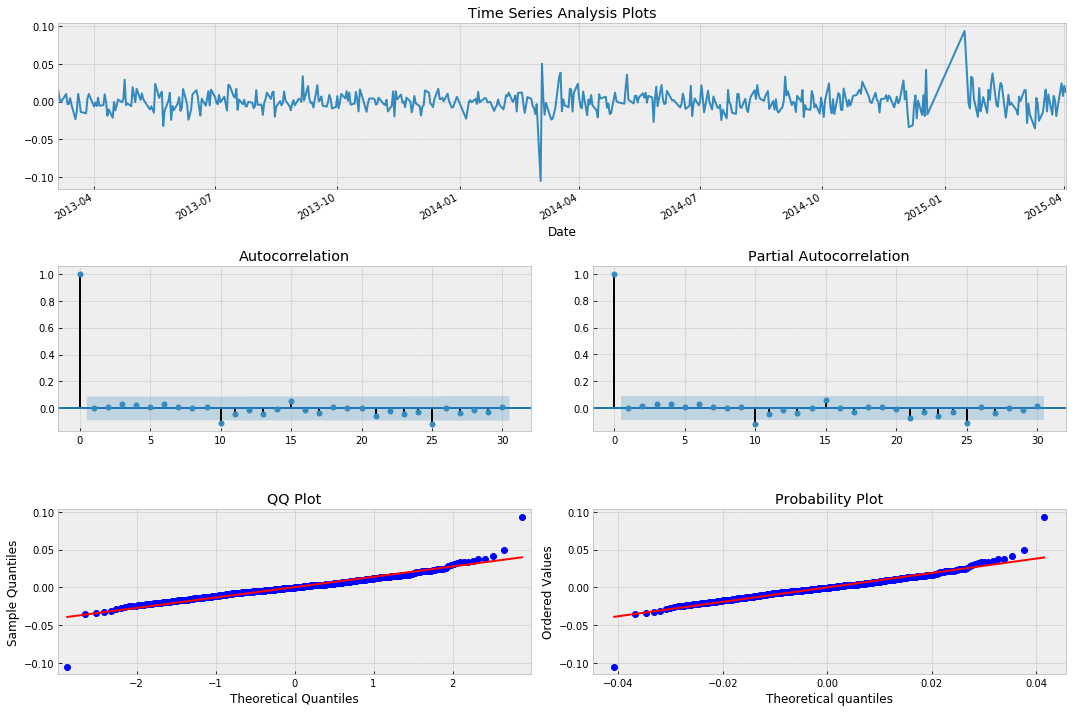

In [139]:
tsplot(model.resid, lags=30)

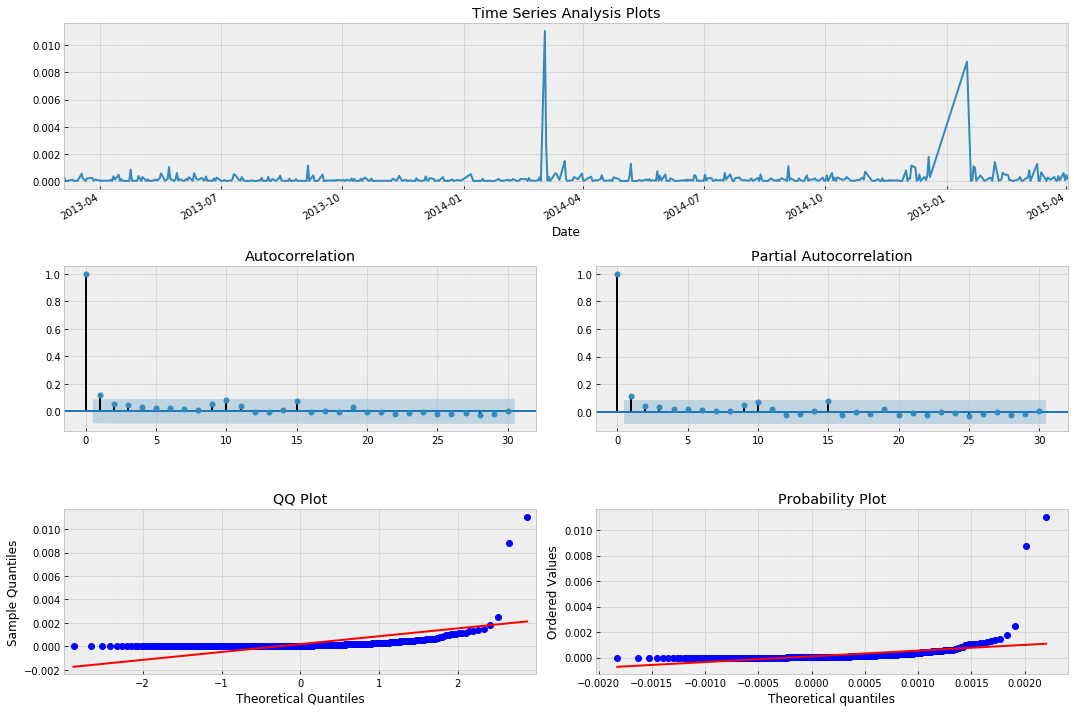

In [140]:
tsplot(model.resid**2, lags=30)

In [143]:
am = arch_model(model.resid*100, p=order[0], o=order[1], q=order[2], dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -807.061
Distribution:      Standardized Student's t   AIC:                           1632.12
Method:                  Maximum Likelihood   BIC:                           1670.05
                                              No. Observations:                  500
Date:                      Thu, Mar 19 2020   Df Residuals:                      491
Time:                              19:56:18   Df Model:                            9
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

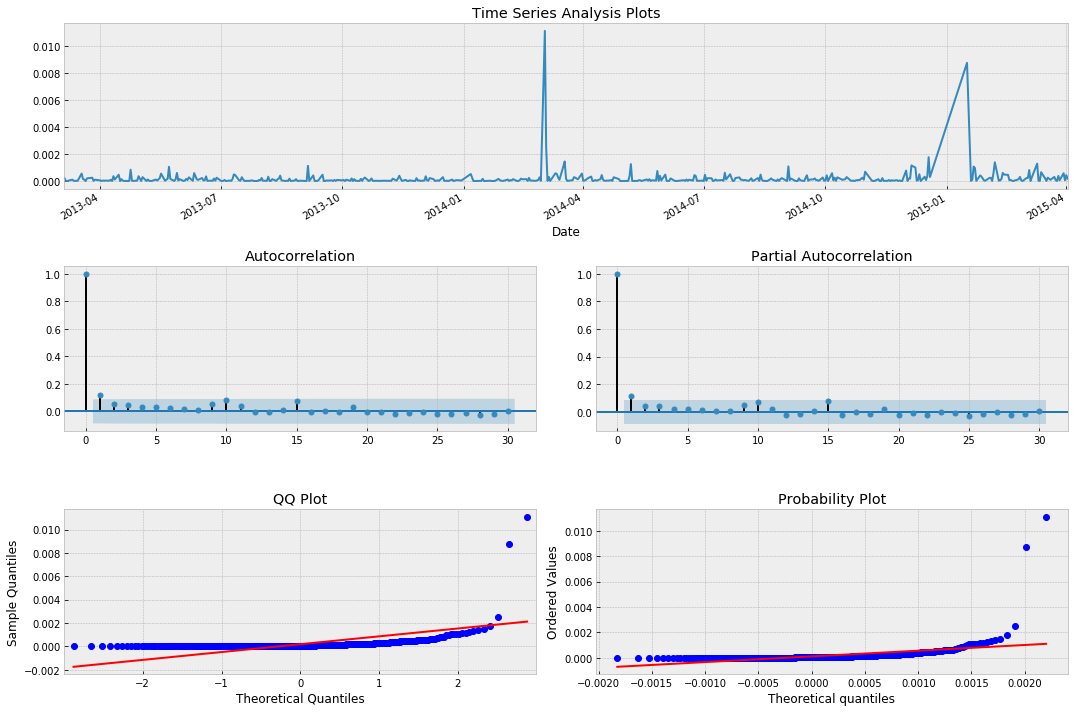

In [147]:
tsplot((res.resid/100)**2, lags=30)